In [1]:
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import unicodedata
import re
import jieba
import numpy as np
import random
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable,List
from torch.utils.data import TensorDataset,RandomSampler,DataLoader

device=torch.device('cuda')

/home/adminroot/miniconda3/envs/distill_data/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_String(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

def normalize_cn_String(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^\u4e00-\u9fff]+", r" ", s)
    return s.strip()

In [3]:
df=pd.read_csv('en_2_cn.tsv',header=None,sep='\t',on_bad_lines='skip')

In [4]:
df.head()

,0,1,2,3
0,1277,I have to go to sleep.,2,我该去睡觉了。
1,1280,Today is June 18th and it is Muiriel's birthday!,5,今天是６月１８号，也是Muiriel的生日！
2,1282,Muiriel is 20 now.,7,Muiriel现在20岁了。
3,1283,"The password is ""Muiriel"".",8,"密码是""Muiriel""。"
4,1284,I will be back soon.,9,我很快就會回來。


In [5]:
# df.iloc[0][3],df.iloc[0][1]
# normalizeString(df.iloc[0][3])
s=unicodeToAscii(df.iloc[0][3])[:4]+'1&&4'+unicodeToAscii(df.iloc[0][3])[4:-1]
print(s)
s=normalize_cn_String(s)
s

我该去睡1&&4觉了


'我该去睡 觉了'

In [6]:
SOS_tokens=0
EOS_token=1
class Lang:
    '''
    Through this class will generate a vocabulary for language
    '''
    def __init__(self,name):
        self.name=name
        self.word2index={}
        self.index2word={0:"SOS",1:"EOS"}
        self.word2count={}
        self.n_words=2 #n_words represent the index of the next word
    def addSentence(self,sentence):
        if self.name=='en':
            for word in sentence.split(' '):
                self.addWord(word)
        else:
            for word in jieba.cut(sentence,cut_all=False):
                self.addWord(word)
    def addWord(self,word):
        if word not in self.word2index:
            self.word2index[word]=self.n_words
            self.index2word[self.n_words]=word
            self.word2count[word]=1
            self.n_words+=1
        else:
            self.word2count[word]+=1

In [7]:
import jieba

# text = "中文分词是一个重要的自然语言处理任务。"
text = "我该去睡觉了"
seg_list = jieba.cut(text, cut_all=False)
print(" ".join(seg_list))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.964 seconds.
Prefix dict has been built successfully.


我 该 去 睡觉 了


In [8]:
pairs=[]
def pair_df(row):
    '''
    split every line into pairs and normalize
    '''
    sentence=[]
    sentence.append(normalize_String(row[1]))
    sentence.append(normalize_cn_String(row[3]))
    pairs.append(sentence)
df.apply(pair_df,axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
67800    None
67801    None
67802    None
67803    None
67804    None
Length: 67805, dtype: object

In [9]:
pairs[:5]

[['i have to go to sleep', '我该去睡觉了'],
 ['today is june th and it is muiriel s birthday !', '今天是 月 号 也是 的生日'],
 ['muiriel is now', '现在 岁了'],
 ['the password is muiriel', '密码是'],
 ['i will be back soon', '我很快就會回來']]

In [10]:
def readLangs(lang1,lang2,pairs,reversed=False):
    '''
    in this use lang1 English lang2 Chinese
    when you want to tarnslate lang2 to lang1 set  reversed True 
    '''
    if reversed:
        pairs=[list(reversed(p))for p in pairs]
        input_lang=Lang(lang2)
        output_lang=Lang(lang1)
    else:
        input_lang=Lang(lang1)
        output_lang=Lang(lang2)
    return input_lang,output_lang,pairs
    

In [11]:
eng_prefixes=(
    "i am ","我是",
    "he is ","他是",
    "she is ","她是",
    "you are ","你是",
    "we are ","我们是",
    "they are ","他们是"
)
a=0
for i in pairs:
    if(i[1].startswith(eng_prefixes)):
        print(i)
        a+=1
        assert a<5


['are you freaking kidding me ? !', '你是在跟我開玩笑吧']
['he s a good person', '他是个好人']
['he s a good person', '他是個好人']
['are you a japanese student ?', '你是日本学生吗']
['are you a japanese student ?', '你是日语学生吗']


AssertionError: 

In [12]:
MAX_LENGTH=15

eng_prefixes=(
    "i am ","我 是 ",
    "he is ","他 是 ",
    "she is ","她 是 ",
    "you are ","你 是 ",
    "we are ","我们 是 ",
    "they are ","他们 是 "
)

def filterPair(p):
    return len(p[0].split(' '))<MAX_LENGTH and \
    len([word for word in jieba.cut(p[1],cut_all=False)])<MAX_LENGTH and \
    p[0].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [13]:
def prepareData(lang1,lang2,pairs,reverse=False):
    '''
    prepare the data from lang1 to lang2, if reverse is False
    '''
    input_lang,output_lang,pairs=readLangs(lang1,lang2,pairs,reverse)
    print(f"Read {len(pairs)} sentence pairs")
    pairs=filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentece pairs")
    print("Counting words \n")
    print("Generate the vocab")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name,input_lang.n_words)
    print(output_lang.name,output_lang.n_words)
    return input_lang,output_lang,pairs

In [14]:
input_lang,output_lang,pairs=prepareData('en','cn',pairs)
print(random.choice(pairs))

Read 67805 sentence pairs
Trimmed to 2247 sentece pairs
Counting words 

Generate the vocab
Counted words:
en 1812
cn 2691
['i am so thirsty probably because i ate pizza yesterday night', '我渴死了 可能是因為我昨天晚上吃了比薩']


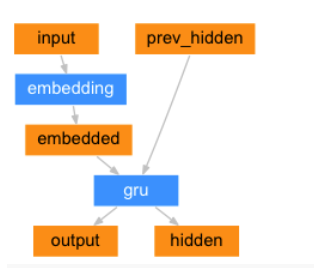

In [15]:
class EncoderRNN(nn.Module):
    '''
    an RNN(Gru) Encoder
    return output,hidden state for next input word
    output [batch_size,seq_len,hidden_size]
    hidden [num_layer*num_direction,batch_size,hidden_size]
    '''
    def __init__(self,input_size,hidden_size,dropout_p=0.1):
        # first batch is time step
        super(EncoderRNN,self).__init__()
        self.hidden_size=hidden_size
        self.embedding=nn.Embedding(input_size,hidden_size)
        self.gru=nn.GRU(hidden_size,hidden_size,batch_first=True)
        self.dropout=nn.Dropout(dropout_p)
    def forward(self,x):
        embedded=self.dropout(self.embedding(x))
        output,hidden=self.gru(embedded)
        return output,hidden

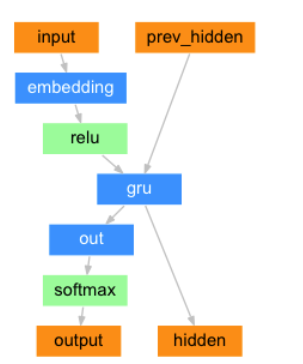

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self,hidden_size,output_size):
        super(DecoderRNN,self).__init__()
        self.embedding=nn.Embedding(output_size,hidden_size)
        self.gru=nn.GRU(hidden_size,hidden_size,batch_first=True)
        self.out=nn.Linear(hidden_size,output_size)
    def forward_step(self,input,hidden):
        output=self.embedding(input)
        output=F.relu(output)
        output,hidden=self.gru(output,hidden)
        output=self.out(output)
        return output,hidden
    def forward(self,encoder_outputs,encoder_hidden,target_tensor=None):
        # target tensor ues for teacher forcing
        batch_size=encoder_outputs.size(0)
        decoder_input=torch.empty(batch_size,1,dtype=torch.long,device=device).fill_(SOS_tokens)
        decoder_hidden=encoder_hidden
        decoder_outputs=[] #the candidate data
        
        for i in range(MAX_LENGTH):
            decoder_output,decoder_hidden=self.forward_step(decoder_input,decoder_hidden)
            # print(decoder_output.size())[32,1,2691]
            # append to list one by one
            decoder_outputs.append(decoder_output)
            if target_tensor is not None:
                decoder_input=target_tensor[:,i].unsqueeze(1)
            else:
                #use the history predict as input
                _,topi=decoder_output.topk(1)
                decoder_input=topi.squeeze(-1).detach()
        decoder_outputs=torch.cat(decoder_outputs,dim=1)
        #calculate log softmax for every outputs
        # decoder_outputs=F.log_softmax(decoder_outputs,dim=-1)
        return decoder_outputs,decoder_hidden,None
    


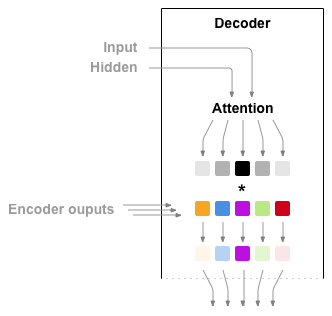

Calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

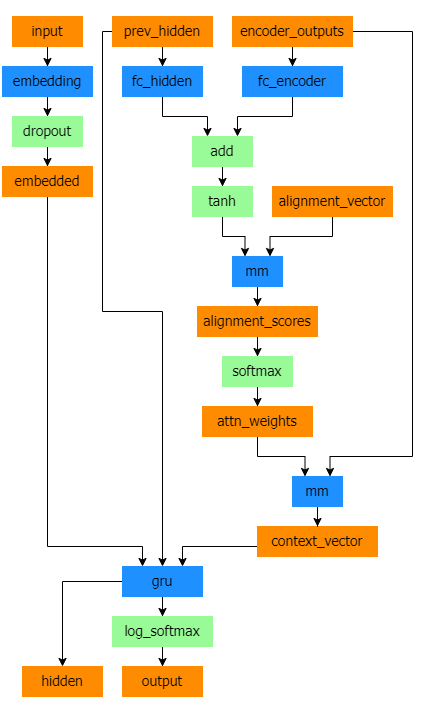

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.


In [17]:
class BahanauAttention(nn.Module):
    '''
    return context contain the information of every word in encoder_output(keys)
    context is [batch_size,1,hidden_size]
    weights [batch_size,1,seq_len]
    '''
    def __init__(self,hidden_size):
        super(BahanauAttention,self).__init__()
        self.W=nn.Linear(hidden_size,hidden_size)
        self.U=nn.Linear(hidden_size,hidden_size)
        self.V=nn.Linear(hidden_size,1) # here is like a mm operation [1,hidden_size]dot[hidden_size,1]
    def forward(self,query,keys):
        # keys [batch_size,seq_len,hidden_size]
        # scores [batch_size,seq_len,1]
        scores=self.V(torch.tanh(self.W(query)+self.U(keys)))
        # print(f'Size of keys is {keys.size()}')
        # scores=scores.squeeze(2).unsqueeze(1)
        scores=scores.transpose(1,2)
        #after operation above scores is [batch_size,1,seq_len] 
        # print(f'Size of score is {scores.size()}')
        weights=F.softmax(scores,dim=-1)
        context=torch.bmm(weights,keys)
        #context is [batch_size,1,hidden_size]
        #context contain the information of every word in encoder_output 该输出为通过rnn编码器后的向量，每一个最后一维是hidden维的，对应编码器隐藏层信息
        return context,weights

class AttentionDecoderRNN(nn.Module):
    def __init__(self,hidden_size,output_size,dropout=0.1):
        super(AttentionDecoderRNN,self).__init__()
        self.embedding=nn.Embedding(output_size,hidden_size)
        self.attention=BahanauAttention(hidden_size)
        self.gru=nn.GRU(2*hidden_size,hidden_size,batch_first=True)
        # self.gru=nn.GRU(hidden_size,hidden_size,batch_first=True)
        self.out=nn.Linear(hidden_size,output_size)
        self.dropout=nn.Dropout(dropout)
        
    def forward_step(self,input,hidden,encoder_outputs):
        embedded=self.dropout(self.embedding(input))
        # hidden [1,32,hidden_size] [num_layer*num_direction,batch_size,hidden_size]
        query=hidden.permute(1,0,2)
        # query [32,1,hidden_size] [batch_size,1,hidden_size]
        context,atten_weights=self.attention(query,encoder_outputs)
        # add information of encoder_outputs and hidden to input
        input_gru=torch.cat((embedded,context),dim=2)
        # input_gru=embedded+context
        output,hidden=self.gru(input_gru,hidden)
        output=self.out(output) #[batch_size,1,output_size]
        return output,hidden,atten_weights
        
    def forward(self,encoder_outputs,encoder_hidden,target_tensor=None):
        batch_size=encoder_outputs.size(0)
        decoder_input=torch.empty(batch_size,1,dtype=torch.long,device=device).fill_(SOS_tokens)
        decoder_hidden=encoder_hidden
        decoder_outputs=[]
        attentions=[]
        for i in range(MAX_LENGTH):
            decoder_output,decoder_hidden,atten_weight=self.forward_step(
                decoder_input,
                decoder_hidden,
                encoder_outputs)
            decoder_outputs.append(decoder_output)
            attentions.append(atten_weight)
            if target_tensor is not None:
                decoder_input=target_tensor[:,i].unsqueeze(1)
            else:
                _,topi=decoder_output.topk(1) #[batch_size,1,1]
                decoder_input=topi.squeeze(-1).detach() #[batch_size,1]
        decoder_outputs=torch.cat(decoder_outputs,dim=1)
        # decoder_outputs=F.log_softmax(decoder_outputs,dim=1)
        attentions=torch.cat(attentions,dim=1)
        return decoder_outputs,decoder_hidden,attentions
            
        
        
        

In [18]:
def indexesFromSentence(lang:Lang,sentence):
    if lang.name=='en':
        return [lang.word2index[word] for word in sentence.split(' ')]
    else:
        return [lang.word2index[word] for word in jieba.cut(sentence,cut_all=False)]

def tensorfromSentence(lang:Lang,sentence):
    # convert sentence to tensor
    indexes=indexesFromSentence(lang,sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes,dtype=torch.long,device=device).view(1,-1)

def tensorfromPair(pair):
    #return tensor of the pair (input_tensor,output_tensor)
    input_tensor=tensorfromSentence(input_lang,pair[0])
    output_tensor=tensorfromSentence(output_lang,pair[1])
    return (input_tensor,output_tensor)

def get_dataloader(batch_size):
    n=len(pairs)
    input_ids=np.zeros((n,MAX_LENGTH),dtype=np.int32)
    target_ids=np.zeros((n,MAX_LENGTH),dtype=np.int32)
    for idx,(inp,tgt) in enumerate(pairs):
        inp_ids=indexesFromSentence(input_lang,inp)
        tgt_ids=indexesFromSentence(output_lang,tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx,:len(inp_ids)]=inp_ids
        target_ids[idx,:len(tgt_ids)]=tgt_ids
    train_data=TensorDataset(torch.LongTensor(input_ids).to(device),
                             torch.LongTensor(target_ids).to(device))
    train_sample=RandomSampler(train_data)
    train_dataloader=DataLoader(train_data,batch_size=batch_size,sampler=train_sample)
    return train_dataloader
        

In [19]:
train_dataloader=get_dataloader(32)

In [20]:
len(next(iter(train_dataloader))),len(train_dataloader)
#src tgt

(2, 71)

In [21]:
def trian_epoch(dataloader,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion):
    total_loss=0.0
    for data in dataloader:
        input_tensor,target_tensor=data
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        encoder_outputs,encoder_hidden=encoder(input_tensor)
        #target tensor is for teacher-forced train
        decoder_outputs,_,_=decoder(encoder_outputs,encoder_hidden,target_tensor)
        #use NLLLoss formula is -log(softmax(outputs)[target])
        loss=criterion(
            decoder_outputs.view(-1,decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss+=loss.item()
    return total_loss/len(dataloader)

In [22]:
import time
import math
def asMinutes(s):
    m=math.floor(s/60)
    s-=m*60
    return f'{m}m {s}s'
def timeSine(since,percent):
    # print current time used and the last time
    now=time.time()
    s=now-since
    es=s/(percent)
    re=es-s
    return f'Duration {s} ,{re} time left |'



## The whole training process
Start a timer

Initialize optimizers and criterion

Create set of training pairs

Start empty losses array for plotting

In [23]:
import matplotlib.pyplot as plt
import matplotlib
# from matplotlib.font_manager import FontProperties
# fontdir = '/home/adminroot/code/pc/study_vlog/deeplearning/torch_tutorial/tanslation_with_tf/SimHei.ttf'
# chinese_font = FontProperties(fname=fontdir)
plt.switch_backend('agg')
# plt.rcParams['font.sans-serif']='SimHei'
import matplotlib.ticker as ticker


def showPlot(points):
    plt.figure()
    # plt.legend(fontdir=fontdir)
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [24]:
def train(train_dataloader,encoder,decoder,n_epochs,lr=0.001,log_epoch=100,plot_epoch=100):
    start=time.time()
    plot_losses=[]
    log_loss_total=0
    plot_loss_total=0

    encoder_optimizer=torch.optim.Adam(encoder.parameters(),lr=lr)
    decoder_optimizer=torch.optim.Adam(decoder.parameters(),lr=lr)
    # criterion=nn.NLLLoss()
    criterion=nn.CrossEntropyLoss()
    

    for epoch in range(1,n_epochs+1):
        loss=trian_epoch(train_dataloader,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion)
        log_loss_total+=loss
        plot_loss_total+=loss
        if epoch%log_epoch==0:
            log_loss_avg=log_loss_total/log_epoch
            log_loss_total=0
            print(f'{timeSine(start,epoch/n_epochs)} | current epoch({epoch} {epoch/n_epochs*100}%) | loss avg:{log_loss_avg}')
        if epoch % plot_epoch==0:
            plot_loss_avg=plot_loss_total/plot_epoch
            plot_losses.append(plot_loss_avg)
            plot_loss_total=0
    showPlot(plot_losses)



In [25]:
def evaluate(encoder,decoder,sentence,input_lang:Lang,output_lang:Lang):
    with torch.no_grad():
        input_tensor=tensorfromSentence(input_lang,sentence)
        encoder_outputs,encoder_hidden=encoder(input_tensor)
        decoder_outputs,_,attentions=decoder(encoder_outputs,encoder_hidden)
        _,topi=decoder_outputs.topk(1)
        decoder_ids=topi.squeeze()
        decoded_word=[]
        for idx in decoder_ids:
            if idx.item()==EOS_token:
                decoded_word.append('<EOS>')
                break
            decoded_word.append(output_lang.index2word[idx.item()])
        return decoded_word,attentions

In [26]:
random.choice(pairs)

['we are spending the night at my uncle s house', '我们在我的叔叔家过夜']

In [27]:
def evaluateRandomly(encoder,decoder,n=5):
    for i in range(n):
        pair=random.choice(pairs)
        print(f"English is :{pair[0]}")
        print(f"中文：{pair[1]}")
        output_words=evaluate(encoder,decoder,pair[0],input_lang,output_lang)
        output_sentence=' '.join(output_words)
        print(f"translation predict is {output_sentence}")

In [28]:
hidden_size=128
batch_size=32
encoder=EncoderRNN(input_lang.n_words,hidden_size).to(device)
# decoder=DecoderRNN(hidden_size,output_lang.n_words).to(device)
decoder=AttentionDecoderRNN(hidden_size,output_lang.n_words).to(device)
train(train_dataloader,encoder,decoder,80,log_epoch=5,plot_epoch=5)


Duration 14.441871404647827 ,216.6280710697174 time left | | current epoch(5 6.25%) | loss avg:2.1191986839536208
Duration 28.171440601348877 ,197.20008420944214 time left | | current epoch(10 12.5%) | loss avg:1.4581324631059673
Duration 41.95329689979553 ,181.79761989911398 time left | | current epoch(15 18.75%) | loss avg:1.0785861885043935
Duration 55.83620524406433 ,167.508615732193 time left | | current epoch(20 25.0%) | loss avg:0.7808718246473394
Duration 69.56828427314758 ,153.0502254009247 time left | | current epoch(25 31.25%) | loss avg:0.5591616444184746
Duration 81.99952363967896 ,136.66587273279825 time left | | current epoch(30 37.5%) | loss avg:0.4016169271838497
Duration 96.06320834159851 ,123.50983929634094 time left | | current epoch(35 43.75%) | loss avg:0.28879803121089936
Duration 109.90704798698425 ,109.90704798698425 time left | | current epoch(40 50.0%) | loss avg:0.20656939111125303
Duration 123.97131633758545 ,96.42213492923312 time left | | current epoch(45

In [46]:
encoder.eval()
decoder.eval()

evaluateRandomly(encoder,decoder)

English is :he is always complaining
中文：他總是在抱怨
translation predict is 他 被 指控 犯有 好 幾起 侵犯   总是 在 调情 说 <EOS>
English is :he is the person whom i saw yesterday
中文：他就是我昨天看到的那個人
translation predict is 他 就是 我 昨天 看到 的 那個 人 <EOS>
English is :he is bound to succeed
中文：他一定会成功
translation predict is 他 沒 有 他 弟弟 聰明 <EOS>
English is :i am good friends with bill
中文：我和比爾是好朋友
translation predict is 我 和 比爾是 好 朋友 之一 <EOS>
English is :we are english
中文：我們是英國人
translation predict is 我们 那时   我 不是 就是 是 朋友 <EOS>


In [39]:
encoder.eval()
decoder.eval()

evaluateRandomly(encoder,decoder)

English is :i am eating a watermelon
中文：我在吃一個西瓜
translation predict is 我 在 吃 一個 西瓜 <EOS>
English is :they are going forwards and i am always going backwards
中文：他们往前走而我一直都在往后退
translation predict is 他们 往前走 而 我 一直 都 在 往 后退 <EOS>
English is :you are too sensitive to criticism
中文：你對批評太敏感了
translation predict is 你 對 批評 太 敏感 了 <EOS>
English is :she is busy right now and she can t speak with you
中文：她現在很忙 不能和你談話
translation predict is 她現 在 很 忙   不能 和 你 談話 <EOS>
English is :i am a member of the tennis club
中文：我是网球俱乐部的会员
translation predict is 我 是 网球 俱乐部 的 会员 <EOS>


In [34]:
encoder.eval()
decoder.eval()

evaluateRandomly(encoder,decoder)

English is :he is apt to forget
中文：他很善忘
translation predict is 他 很 善忘 <EOS>
English is :i am studying computer science
中文：我在学习计算机科学
translation predict is 我 确信 不好 <EOS>
English is :i am happy
中文：我很高兴
translation predict is 我 很 高兴 想 相处 問題 問題 果實 学 句子 不好 高兴 <EOS>
English is :i am tired of homework
中文：我厭倦了功課
translation predict is 我 的 回家 作業 了 了 会 离开 <EOS>
English is :we are to meet him at seven this evening
中文：我們今天晚上七點跟他見面
translation predict is 我們 今天 晚上 七點 跟 他 見面 做 另 一个 决定 买 哪个 <EOS>


In [31]:
def showattention(input_sentence, output_words, attentions):
    # plt.legend(prop=chinese_font)
    plt.rcParams['font.sans-serif']='SimHei'
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')  #通过attentions矩阵获得值
    fig.colorbar(cax)  #设置颜色条
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'],
                       rotation=90)
    # print(output_words)
    ax.set_yticklabels([''] + output_words)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig(
        '/home/adminroot/code/pc/study_vlog/deeplearning/torch_tutorial/tanslation_with_tf/atten.png'
    )
    plt.close()
    # plt.show()


def evaluateandshowattention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence,
                                        input_lang, output_lang)
    print(f'input : {input_sentence}')
    print('output :',''.join(output_words))
    showattention(input_sentence,output_words,attentions[0,0:len(output_words),:])

In [37]:
# from matplotlib.backends.backend_pdf import PdfPages

evaluateandshowattention('i am studying computer science')
# evaluateandshowattention('she is busy right now and she can t speak with you')

# pdf = PdfPages(
#     '/home/adminroot/code/pc/study_vlog/deeplearning/torch_tutorial/tanslation_with_tf/atten.pdf'
# )
# pdf.savefig()
# plt.close()
# pdf.close()

input : i am studying computer science
output : 我在学习计算机科学<EOS>


/tmp/ipykernel_2013758/237762821.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'],
/tmp/ipykernel_2013758/237762821.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
